In [5]:
from navec import Navec
import numpy as np

model = Navec.load('navec_hudlit_v1_12B_500K_300d_100q.tar')

In [15]:
import pandas as pd
from src.parse_assessment import parse_assessment
pd.set_option('display.max_columns', 100, 'display.max_rows', 100)

df = parse_assessment('data/Assessment.xlsx')

keyword_columns = df.columns[df.columns.str.contains('keywords') & (df.notna().sum() > 100)]

In [16]:
df[keyword_columns + ' vector'] = df[keyword_columns].apply(lambda column:
    column.apply(lambda text:
        np.array([model.get(word) for word in text.split(" ") if word in model.vocab]).mean(0)
        if type(text) == str else
        float('nan')
    )
)

/home/akkyma/anaconda3/envs/vosk/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: Mean of empty slice.
  after removing the cwd from sys.path.


In [17]:
import torch
from torch import nn

class Classifier(nn.Module):
    def __init__(self, embedding, classes):
        super().__init__()
        self.layer = nn.Linear(embedding, classes)
    
    def forward(self, vector):
        X = self.layer(vector)
        return X
    
    def predict(self, vector):
        scores = self.forward(vector)
        return scores.argmax(1)

In [18]:
from tqdm import tqdm
from torch.optim import Adam
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

epochs = 1000
batch_size = 1024
device = torch.device('cuda:0')
data = [(vector, column_index) for column_index, column in enumerate(keyword_columns + ' vector')
                               for vector in df[column][df[column].notna()]]
train, test = train_test_split(data, train_size=0.8, stratify=[x[1] for x in data])
X_train, y_train = torch.FloatTensor([x[0] for x in train]), torch.FloatTensor([x[1] for x in train])

classifier = Classifier(300, len(keyword_columns)).to(device)
optim = Adam(classifier.parameters(), lr=0.0005)
softmax = nn.Softmax(dim=1)
pbar = tqdm(range(epochs))
weighted_loss = 0
loss_exp = 0.95
norm_koef = 1
for epoch in pbar:
    for vector, label in DataLoader(train, batch_size=batch_size, shuffle=True):
        vector, label = vector.to(device), label.to(device)
        scores = classifier(vector)
        loss = softmax(scores).log()[range(scores.shape[0]), label]
        loss = -loss.mean()
        
        weighted_loss = (weighted_loss * loss_exp) + (loss.item() * (1 - loss_exp))
        norm_koef *= loss_exp
        normed_loss = weighted_loss / (1 - norm_koef)
        
        optim.zero_grad()
        loss.backward()
        optim.step()
        pbar.set_postfix(loss=weighted_loss)

100%|██████████| 1000/1000 [01:04<00:00, 15.62it/s, loss=1.33]


In [19]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt

X_test, y_test = torch.FloatTensor([x[0] for x in test]), torch.FloatTensor([x[1] for x in test])
pred = classifier.predict(torch.FloatTensor(X_test).to(device)).cpu()
print(classification_report(y_test, pred))

matrix = confusion_matrix(y_test, pred, normalize='true', labels=keyword_columns)
plt.imshow(matrix)
plt.colorbar()
plt.show()

/home/akkyma/anaconda3/envs/vosk/lib/python3.7/site-packages/sklearn/metrics/_classification.py:289: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  elif np.all([l not in y_true for l in labels]):


              precision    recall  f1-score   support

         0.0       0.35      0.21      0.26        71
         1.0       0.35      0.41      0.38       147
         2.0       0.28      0.25      0.26        32
         3.0       0.45      0.42      0.43        24
         4.0       0.37      0.34      0.35        91
         5.0       0.65      0.63      0.64       105
         6.0       0.48      0.57      0.52        21
         7.0       0.32      0.28      0.30        93
         8.0       0.24      0.21      0.22        85
         9.0       0.51      0.56      0.54        98
        10.0       0.53      0.22      0.31        45
        11.0       0.22      0.08      0.12        25
        12.0       0.50      0.24      0.33        29
        13.0       0.42      0.49      0.45        51
        14.0       0.56      0.37      0.44        27
        15.0       0.26      0.17      0.21        29
        16.0       0.52      0.74      0.61       239
        17.0       0.90    

ValueError: At least one label specified must be in y_true

In [12]:
from xgboost import XGBClassifier

xg_model = XGBClassifier().fit(X_train.numpy(), y_train.numpy())

              precision    recall  f1-score   support

           0       0.79      0.63      0.70       147
           1       0.88      0.71      0.79       105
           2       0.75      0.91      0.82       239

    accuracy                           0.78       491
   macro avg       0.81      0.75      0.77       491
weighted avg       0.79      0.78      0.78       491



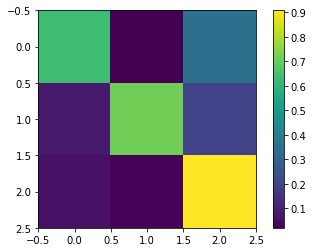

In [13]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt

X_test, y_test = np.array([x[0] for x in test]), np.array([x[1] for x in test])
pred = xg_model.predict(X_test)
print(classification_report(y_test, pred))

matrix = confusion_matrix(y_test, pred, normalize='true')
plt.imshow(matrix)
plt.colorbar()
plt.show()